In [186]:
from astropy import units as u
from astropy import time

import numpy as np

from poliastro import iod
from poliastro.bodies import Mars, Earth, Sun
from poliastro.ephem import Ephem
from poliastro.maneuver import Maneuver
from poliastro.twobody import Orbit
from poliastro.util import time_range
from poliastro.plotting import OrbitPlotter3D, StaticOrbitPlotter
import math

# More info: https://plotly.com/python/renderers/
import plotly.io as pio

pio.renderers.default = "plotly_mimetype+notebook_connected"

from astropy.coordinates import solar_system_ephemeris


solar_system_ephemeris.set("jpl")

<ScienceState solar_system_ephemeris: 'jpl'>

c:\Users\jacki\miniforge-pypy3\envs\python_3.9\lib\site-packages\erfa\core.py:133: ErfaWarning:

ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"

c:\Users\jacki\miniforge-pypy3\envs\python_3.9\lib\site-packages\erfa\core.py:133: ErfaWarning:

ERFA function "utctai" yielded 1 of "dubious year (Note 3)"

c:\Users\jacki\miniforge-pypy3\envs\python_3.9\lib\site-packages\erfa\core.py:133: ErfaWarning:

ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"



Starship DV is 8190.8137793939595m/s
Ejection is with 5671m/s of DV
Reserve DV (not accounting for boiloff) is 2019.8137793939595m/s
departure on 2035-07-15 00:02:09.184
arrival on 2035-10-13 00:02:09.184


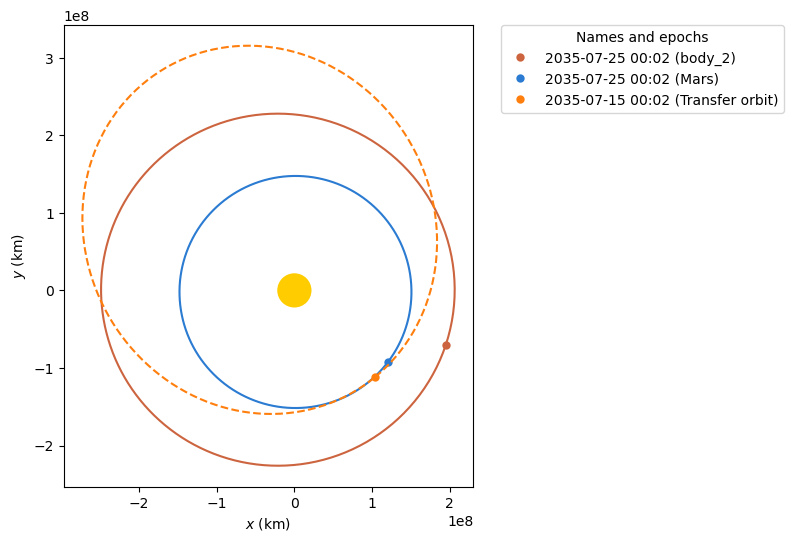

In [187]:
#starship specs
isp = 380
dry_mass = 150
prop_mass = 1200
landing_reserve = 500
starship_dv = isp*9.81*math.log((dry_mass+prop_mass)/dry_mass)
boiloff = 0#0 


#launch from body_1 to body_2
body_1 = Earth
body_2 = Mars


#solve for a minimum ejection DV given a time period
transitTime = 90*u.day
resolution = 10*u.day
start_date = time.Time("2034-01-01 00:01", scale="utc").tdb
end_date = time.Time("2037-01-01 00:01", scale="utc").tdb

ephem_1 = Ephem.from_body(body_1, time_range(start_date, end=end_date+transitTime))
ephem_2 = Ephem.from_body(body_2, time_range(start_date, end=end_date+transitTime))


delta_time = end_date-start_date
lowest_dv = 100000
lowest_date = 0
lowest_orb = 0
for i in range(int(delta_time/resolution)):
    date_launch = start_date+i*resolution
    date_arrival = start_date+transitTime+i*resolution
    # Solve for departure and target orbits
    ss_planet_1 = Orbit.from_ephem(Sun, ephem_1, date_launch)
    ss_planet_2 = Orbit.from_ephem(Sun, ephem_2, date_arrival)

    # Solve for the transfer maneuver
    man_lambert = Maneuver.lambert(ss_planet_1, ss_planet_2)
    ejection = man_lambert[0]
    dv = np.linalg.norm(ejection[1].value)
    if(dv<lowest_dv):
        lowest_dv=dv
        lowest_date = date_launch
        lowest_orb,final = ss_planet_1.apply_maneuver(man_lambert, intermediate=True)


reserve_dv = starship_dv-int(lowest_dv)-landing_reserve
print(f"Starship DV is {starship_dv}m/s")   
print(f"Ejection is with {int((1-boiloff)*lowest_dv)}m/s of DV")
print(f"Reserve DV (not accounting for boiloff) is {reserve_dv}m/s")
print(f"departure on {lowest_date}")
print(f"arrival on {lowest_date+transitTime}")
      
dM = 10*u.day
# We can check new bodies positions
plotter = StaticOrbitPlotter()
plotter.plot_body_orbit(body_2,  lowest_date+dM, label="body_2")
plotter.plot_body_orbit(body_1,  lowest_date+dM, label="Mars")

plotter.plot(lowest_orb, color="C1", label="Transfer orbit")

In [ ]:
#for the optimized trajectory, re get the epherimis
date_launch = lowest_date
date_arrival = lowest_date+transitTime
#ss_earth = Orbit.from_ephem(Sun, earth, date_launch)

#arrival body is body 2
ss_body_2 = Orbit.from_ephem(Sun, ephem_2, date_arrival)


#calculate SOI crossing point
ss_transfer = lowest_orb
ss_final = lowest_orb
time_sliver = 0.01*u.day
steps = int(((transitTime+3*u.day)/time_sliver).value)
print(f"{steps} steps")
soi_change_point = lowest_date+transitTime
for i in range(steps):
    ss_final = ss_transfer.propagate(i*time_sliver)
    arrival_distance = np.linalg.norm(ss_final.r-ss_body_2.r)
    #print(earth_distance)
    grav_difference = Sun.mass/(np.linalg.norm(ss_final.r)**2)-body_2.mass/((arrival_distance)**2)
    #print(grav_difference)
    if(grav_difference<0):
        print(f"arrival at step{i}")
        soi_change_point = date_launch+i*time_sliver
        break


print(f"Normal arrival would be {date_arrival}")
print(f"Actual arrival at {soi_change_point}")



9300 steps


Soi change at 116011.90259581509 km (potentially seems low tbf)
C3 is 70.19321708805558 km2 / s2
[0.13702288 0.99056788 0.        ]
[0.83967707 6.07020626 0.        ] km / s
[ 2565.1648425 -9227.6684004     0.       ] km
Arrival velocity would be 9.738285423781743 km / s
After deacceleration burn it is 7.49187521723197 km / s
Need to lose 2.39187521723197km/s of velocity in initial aerocapture pass


c:\Users\jacki\miniforge-pypy3\envs\python_3.9\lib\site-packages\erfa\core.py:133: ErfaWarning:

ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"

c:\Users\jacki\miniforge-pypy3\envs\python_3.9\lib\site-packages\erfa\core.py:133: ErfaWarning:

ERFA function "utctai" yielded 1 of "dubious year (Note 3)"

c:\Users\jacki\miniforge-pypy3\envs\python_3.9\lib\site-packages\erfa\core.py:133: ErfaWarning:

ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"

c:\Users\jacki\miniforge-pypy3\envs\python_3.9\lib\site-packages\erfa\core.py:133: ErfaWarning:

ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"

c:\Users\jacki\miniforge-pypy3\envs\python_3.9\lib\site-packages\erfa\core.py:133: ErfaWarning:

ERFA function "utctai" yielded 1 of "dubious year (Note 3)"

c:\Users\jacki\miniforge-pypy3\envs\python_3.9\lib\site-packages\erfa\core.py:133: ErfaWarning:

ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"



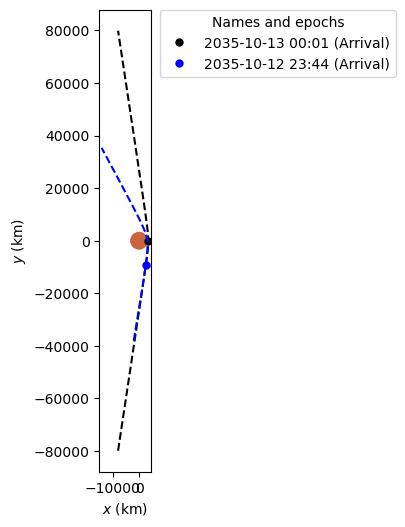

In [ ]:
#ITS BROKEN AND I UNDERSTAND WHY



retro_time = 1000*u.second #how long before entry interface to do the retro burn

ss_final = lowest_orb.propagate(soi_change_point-date_launch) 


r_body_2, v_body_2 = ss_body_2.r,ss_body_2.v
r_sc_arriv = ss_final.r-r_body_2
v_sc_arriv = ss_final.v-v_body_2
c3_a = np.linalg.norm(v_sc_arriv)**2
print(f"Soi change at {np.linalg.norm(r_sc_arriv)} (potentially seems low tbf)")
print(f"C3 is {c3_a}")


#C3 only orbit calc
r_p = 80*u.km#arrival periapsis
a_exit = -(body_2.k / c3_a).to(u.km)
ecc_exit = 1 - (r_p+body_2.R) / a_exit

arrival_orbit = Orbit.from_classical(
    body_2,
    a_exit,
    ecc_exit,
    0 * u.deg,
    0 * u.deg,
    0 * u.deg,
    0 * u.deg,  # We don't mind
    time.Time(date_arrival, scale="utc"),
)
pre_burn_orbit = arrival_orbit.propagate(-retro_time)
#perform the retro burn
prograde_vector = (pre_burn_orbit.v/(np.linalg.norm(pre_burn_orbit.v))).value
print(prograde_vector)
burn_dv = -0.001*reserve_dv*prograde_vector
retro_burn = Maneuver((0*u.s,burn_dv*u.km/u.s))
#retro_burn = Maneuver((0*u.s,[0,1,0]*u.km/u.s))
post_burn_orbit = pre_burn_orbit.apply_maneuver(retro_burn)


earth_plotter = StaticOrbitPlotter()

earth_plotter.plot(arrival_orbit, label="Arrival", color="k")
earth_plotter.plot(post_burn_orbit, label="Arrival", color="b")
print(post_burn_orbit.v)
print(post_burn_orbit.r)

post_burn_orbit = post_burn_orbit.propagate(-post_burn_orbit.t_p)


print(f"Arrival velocity would be {np.linalg.norm(arrival_orbit.v)}")
print(f"After deacceleration burn it is {np.linalg.norm(post_burn_orbit.v)}")
print(f"Need to lose {np.linalg.norm(post_burn_orbit.v).value-5.1}km/s of velocity in initial aerocapture pass")

####code below tries to calculate real orbit, but patched conics problems force a c3 only calculation orbit tbf

# #grav_difference = Sun.mass/(np.linalg.norm(ss_final.r)**2)-Earth.mass/(np.linalg.norm(r_sc_arriv)**2)
# print(grav_difference)

# arrival_orbit = Orbit.from_vectors(Earth,r_sc_arriv,v_sc_arriv,epoch=date_arrival-offset_time)
# #arrival_orbit = arrival_orbit.propagate(0.3*u.day)
# print(arrival_orbit)
# print(f"This orbit gets to within {arrival_orbit.r_p-Earth.R} of the surface of earth")
# print(f"Earth position at {lowest_date}")

# earth_plotter = StaticOrbitPlotter()

# earth_plotter.plot(arrival_orbit, label="earth Arrival", color="k")





4.919720457330396 km2 / s2
-29.843687369317966 km2 / s2
Ejection DV is 5.896050188613422 km / s
6678 x 6678 km x 0.0 deg (GCRS) orbit around Earth (♁) at epoch 2035-07-15 00:02:09.184 (TDB)
6780 x -87801 km x 140.4 deg (GCRS) orbit around Earth (♁) at epoch 2035-07-15 00:02:09.184 (TDB)


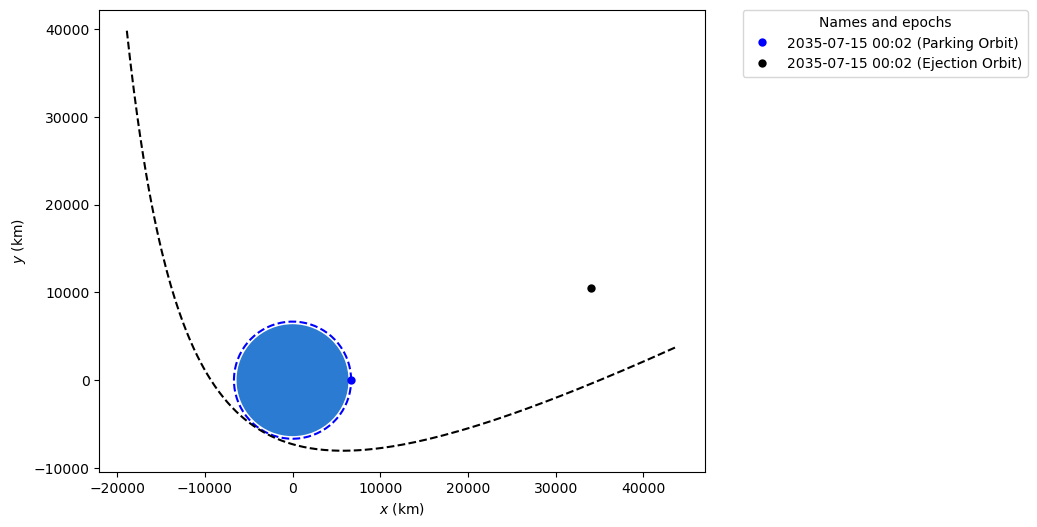

In [ ]:
#for the optimized trajectory, re get the epherimis
date_launch = lowest_date
date_arrival = lowest_date+transitTime
ss_earth = Orbit.from_ephem(Sun, earth, date_launch)
ss_mars = Orbit.from_ephem(Sun, mars, date_arrival)




#ejection from Earth
#calculate departure orbit
prop_time = 0.012*u.day

ss_leave = lowest_orb.propagate(prop_time)
r_earth,v_earth=ss_earth.r,ss_earth.v
r_traj_leave = ss_leave.r-r_earth
v_traj_leave = ss_leave.v-v_earth


ejection_orbit = Orbit.from_vectors(Earth,r_traj_leave,v_traj_leave,epoch = date_launch)
#ejection_orbit.inc = 0*u.rad
#propogate ejection_orbit to periapsis



parking_orbit = Orbit.circular(Earth,inc=0*u.rad, alt=300 << u.km,epoch = date_launch)



print(ejection_orbit.energy)# = 0*u.rad
print(parking_orbit.energy)

#calculate ejection DV
#print(parking_orbit.v)
dE = ejection_orbit.energy-parking_orbit.energy
dV=np.sqrt(dE)
print(f"Ejection DV is {dV}")


print(parking_orbit)
print(ejection_orbit)
earth_ejection_plotter = StaticOrbitPlotter()

ejection_orbit.inc = 0*u.rad
earth_ejection_plotter.plot(parking_orbit, label="Parking Orbit", color="b")
earth_ejection_plotter.plot(ejection_orbit, label="Ejection Orbit", color="k")